This is the notebook for unsupervised learning, as well as filter visualization

## Hyperparameters

In [ ]:
# image size to downsample to
downsampled_size = 9

batch_size = 128

# margin for triplet loss function
margin = 1.

n_epochs = 1200
# log every x batches
log_interval = 20

# Convnet hyperparameters
lr = 1e-3
input_depth = 3
layer1_stride = 1
layer1_kernel_size = 8
layer1_output_channels = 64
layer1_padding = 0

visualize_filter = True

# Number of examples to visualize and see how the network embeds
visualize_model_working = 0

## Dataset setup

In [ ]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
import utils
from datasets import DownsampledCIFAR100
import torch


train_dataset = CIFAR100('./data/CIFAR100', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                             ]))
test_dataset = CIFAR100('./data/CIFAR100', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                            ]))

downsampled_train_dataset = DownsampledCIFAR100(train_dataset, downsampled_size=downsampled_size)
downsampled_test_dataset = DownsampledCIFAR100(test_dataset, downsampled_size=downsampled_size)

cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(downsampled_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(downsampled_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## ConvNet setup

In [ ]:
from torch.optim import lr_scheduler
import torch.optim as optim
from trainer import fit
from networks import EmbeddingNet, TripletNet, OnlineTripletNet
from losses import TripletLoss, OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, \
    RandomNegativeTripletSelector, SemihardNegativeTripletSelector

embedding_net = EmbeddingNet(input_depth=input_depth,
                             layer1_stride=layer1_stride,
                             layer1_kernel_size=layer1_kernel_size,
                             layer1_output_channels=layer1_output_channels,
                             layer1_padding=layer1_padding)
model = OnlineTripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))
optimizer = optim.Adam(model.parameters(), lr=lr)

# learning rate decay over epochs
scheduler = lr_scheduler.StepLR(optimizer, 1000, gamma=0.1, last_epoch=-1)

## Train and test model

In [ ]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, visualize_workings=visualize_model_working)

## Save filter visualization

In [ ]:
if visualize_filter:
    filename = "visualization_unsupervised"
    # Reset
    open(filename, 'w').close()

    for filter in list(model.embedding_net.convnet.parameters())[0]:
        filter = utils.normalize_01(filter)
        utils.save_image_visualization(filter.detach().cpu().numpy(),
                                       filename=filename)

## Save first layer of model

In [ ]:
torch.save(model.embedding_net.convnet[0].state_dict(), 'model_unsupervised.pt')

## Visualize filters

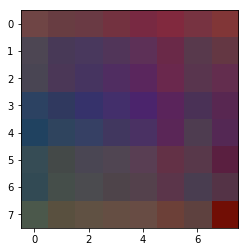

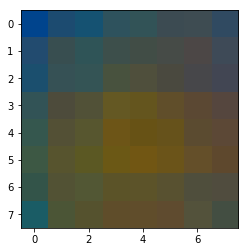

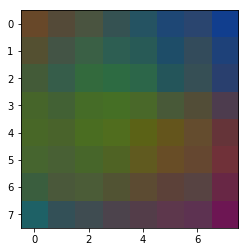

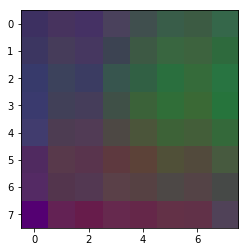

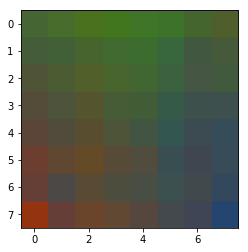

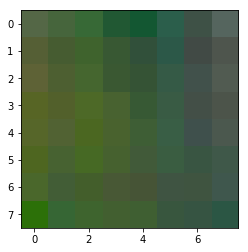

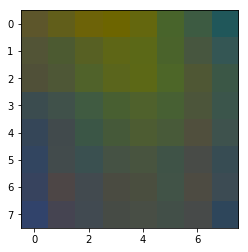

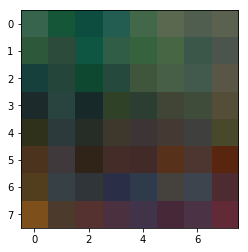

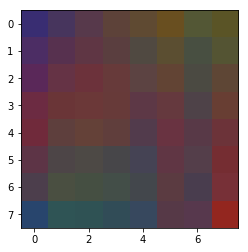

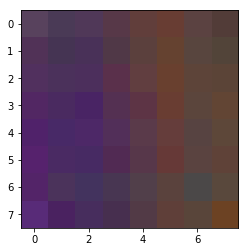

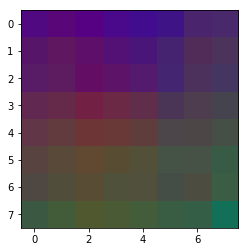

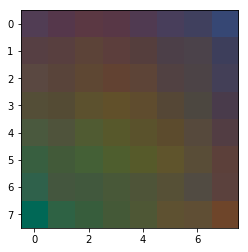

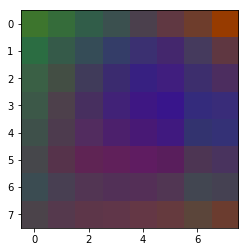

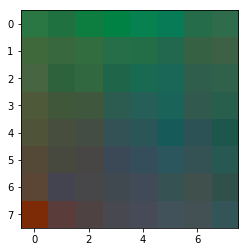

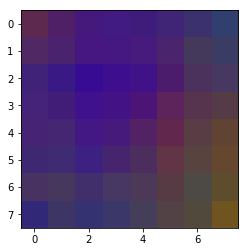

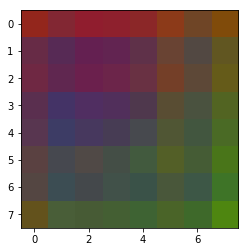

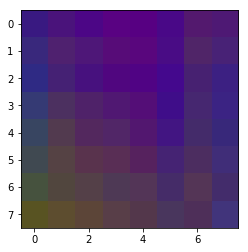

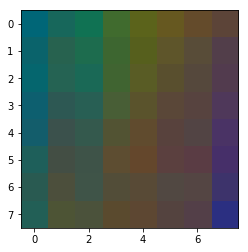

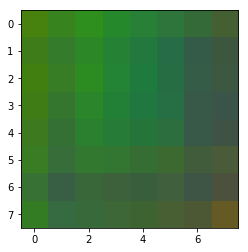

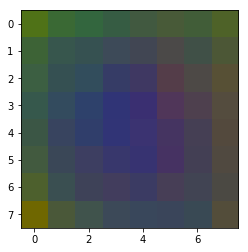

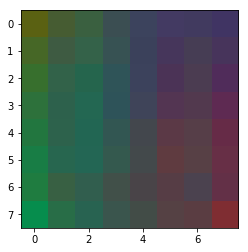

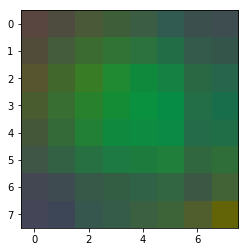

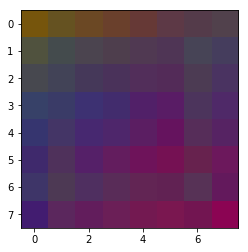

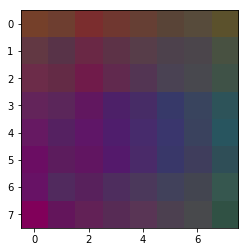

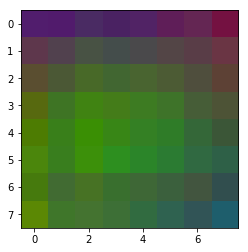

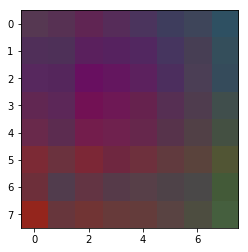

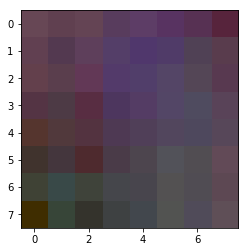

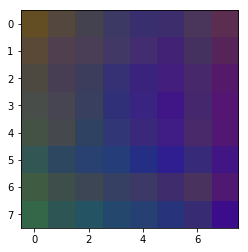

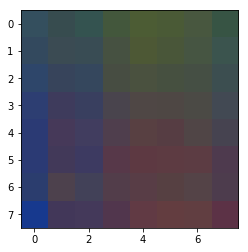

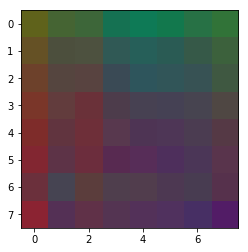

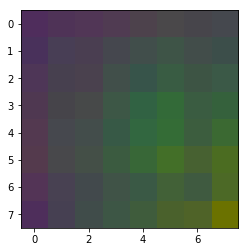

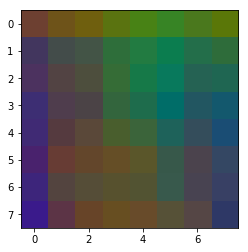

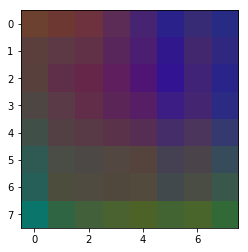

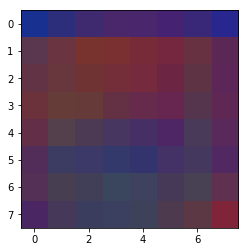

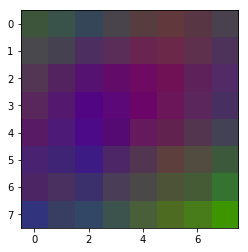

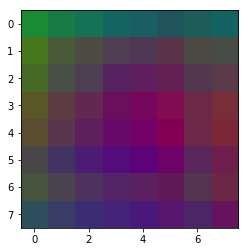

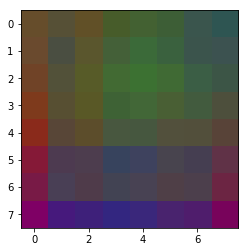

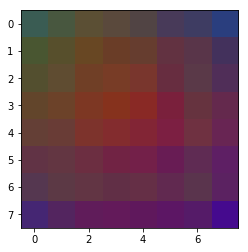

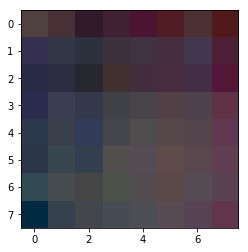

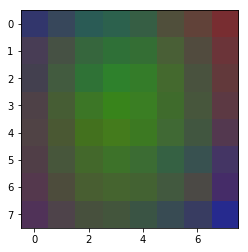

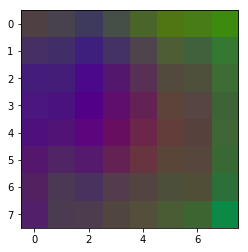

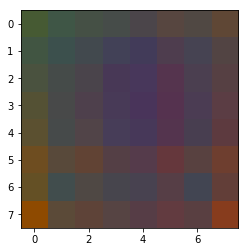

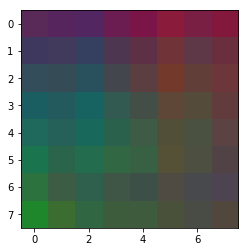

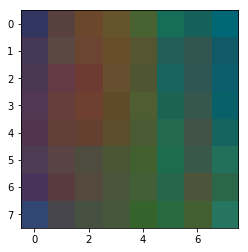

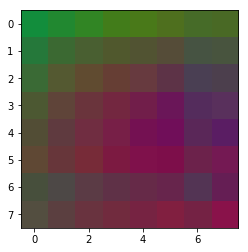

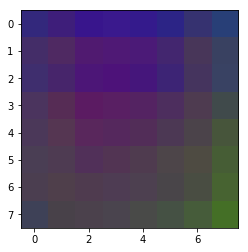

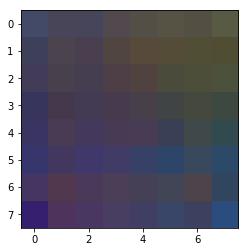

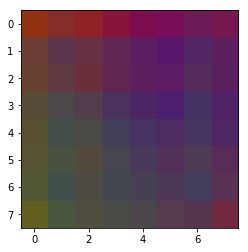

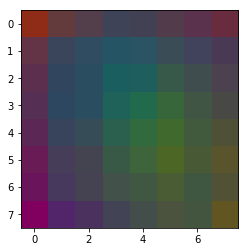

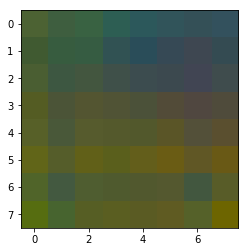

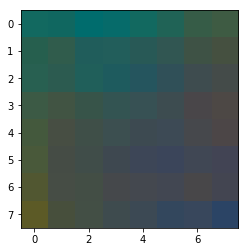

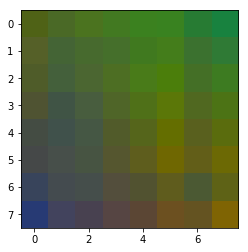

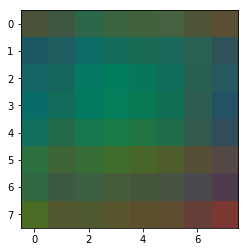

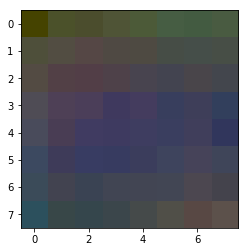

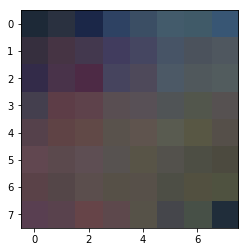

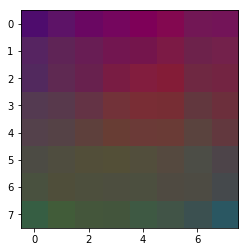

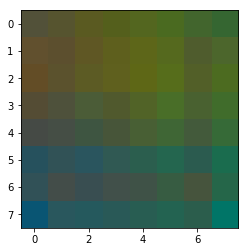

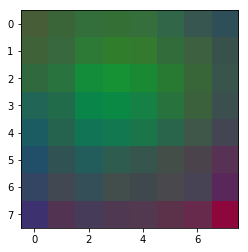

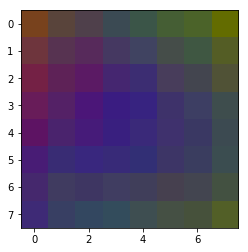

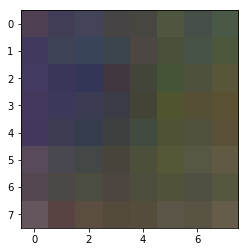

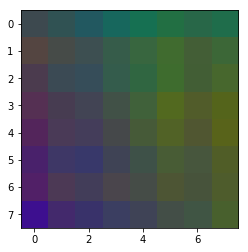

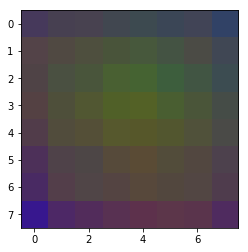

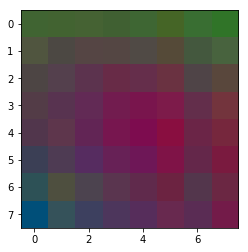

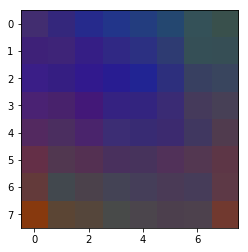

In [3]:
%matplotlib inline
import utils
filename = "visualization_unsupervised"
# filename = "visualization_unsupervised_9size_1stride_1200"
# filename = "visualization_unsupervised_9size_1stride_500_2"
# filename = "visualization_unsupervised_16size_4stride"
utils.visualize_image_from_file(filename)

## Compare to supervised CNN filters

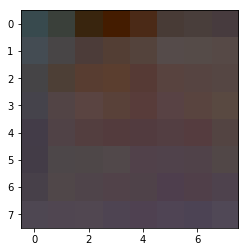

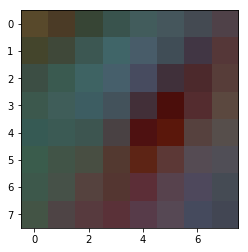

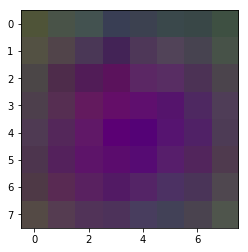

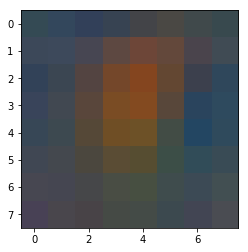

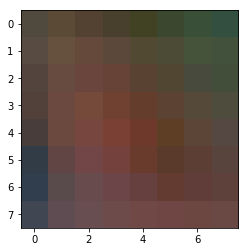

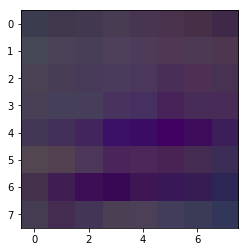

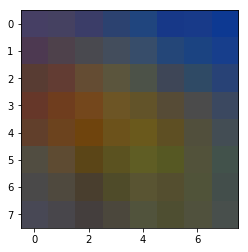

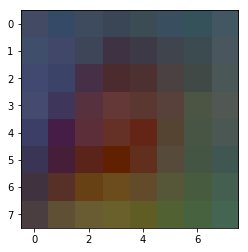

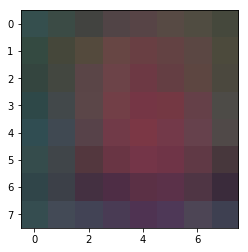

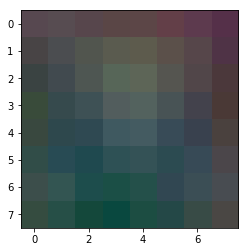

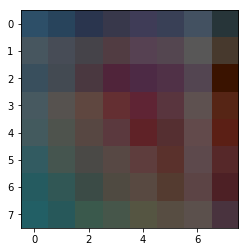

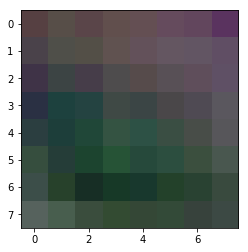

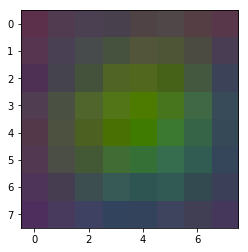

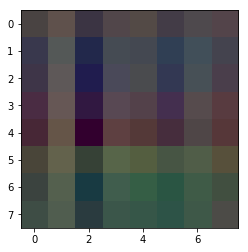

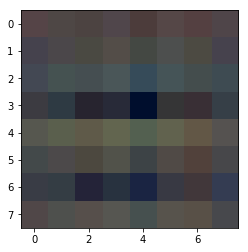

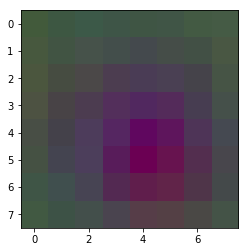

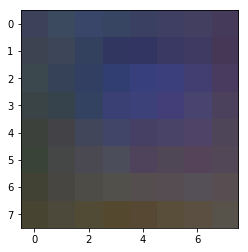

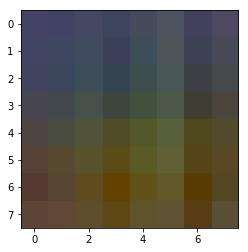

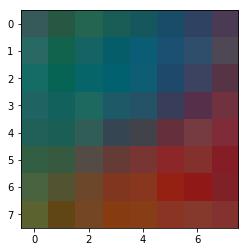

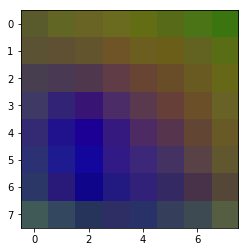

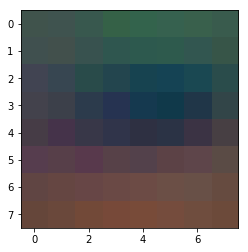

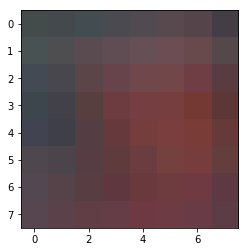

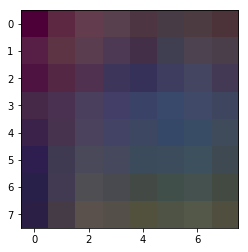

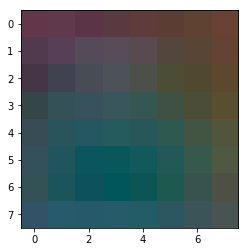

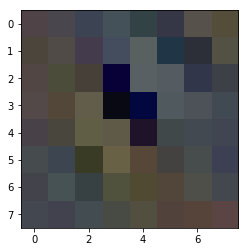

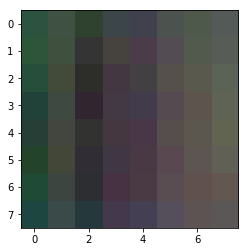

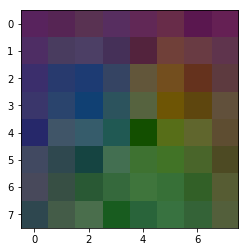

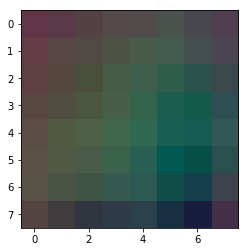

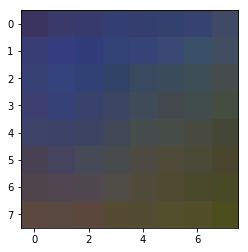

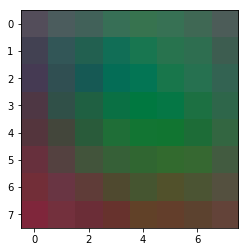

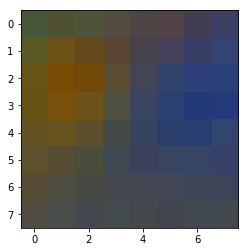

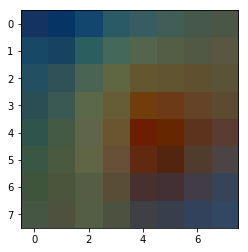

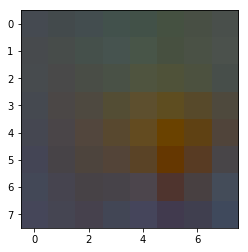

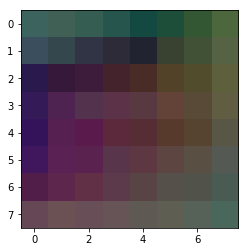

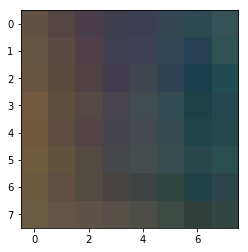

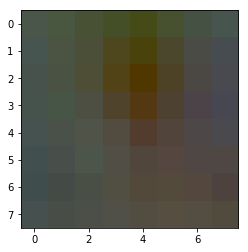

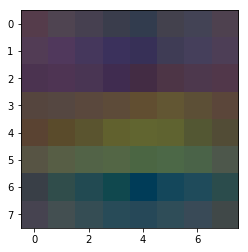

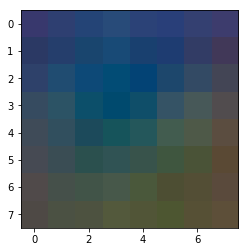

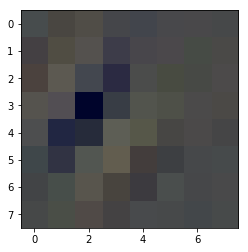

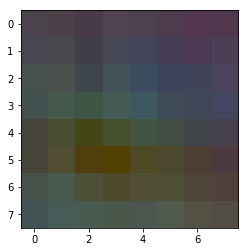

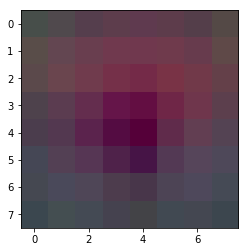

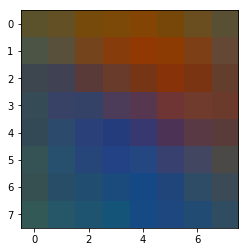

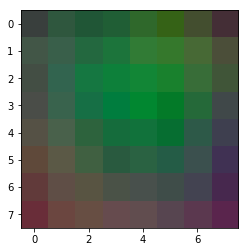

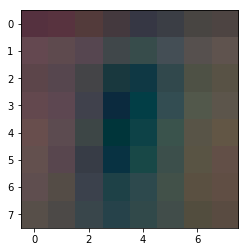

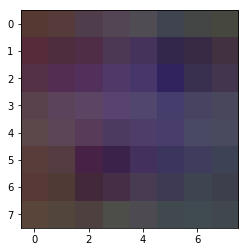

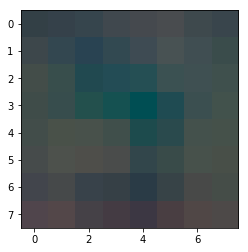

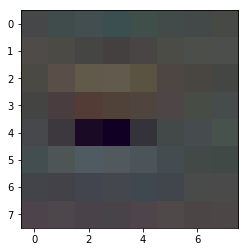

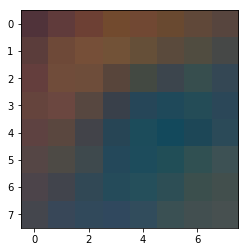

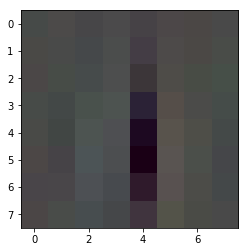

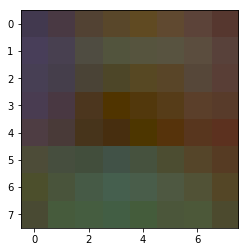

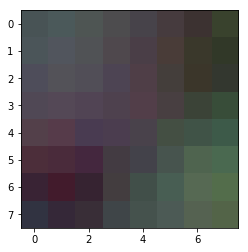

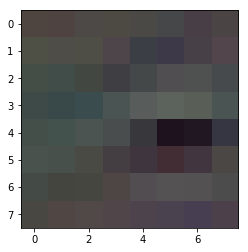

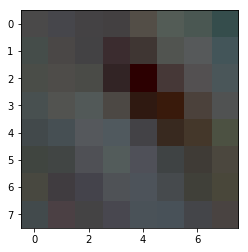

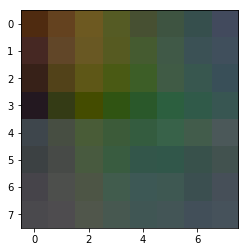

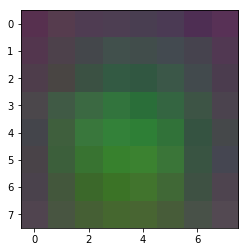

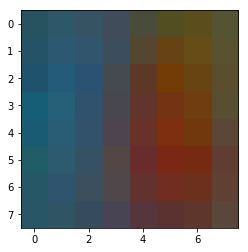

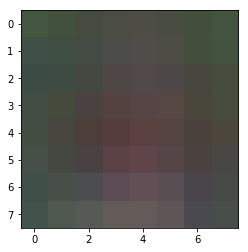

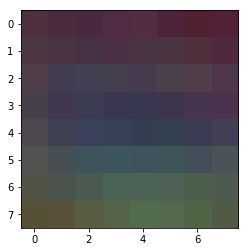

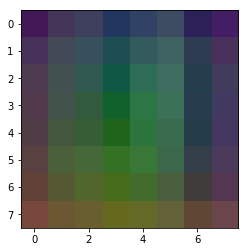

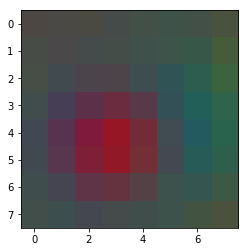

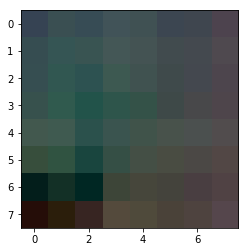

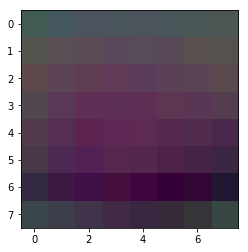

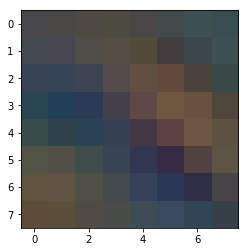

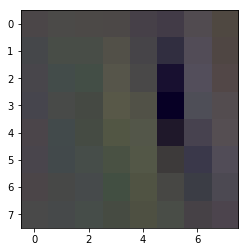

In [1]:
%matplotlib inline
import utils
filename = "visualization"
utils.visualize_image_from_file(filename)